In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
sys.path.insert(0,"/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.misc import *

In [3]:
data_path = "/home/rzhu/data_access/l2l_data/logs/LTL-NWN-volterra-SA/run-no-2023-04-01-194347/"

In [4]:
fnames = os.listdir(data_path +"per_gen_trajectories")
fnames.sort()
n_gens = len(fnames)

In [5]:
results = []
for fn in fnames:
    fileName = os.path.join(data_path, "per_gen_trajectories", fn)
    temp = pkl_load(fileName)
    gen_out = torch.tensor([r[1][0] for r in temp.current_results])
    results.append(gen_out)

n_ins = len(gen_out)
results = torch.stack(results)

In [6]:
hyper_keys = temp.individual.__dict__["params"].keys()
hyper_dict = {}

for key in hyper_keys:
    hyper_dict[key] = torch.zeros(n_gens, n_ins)
    for i in range(n_gens):
        for j in range(n_ins):
            hyper_dict[key][i][j] = temp.individuals[i][j].__dict__["params"][key]

Text(0, 0.5, 'Pre initialization time (s)')

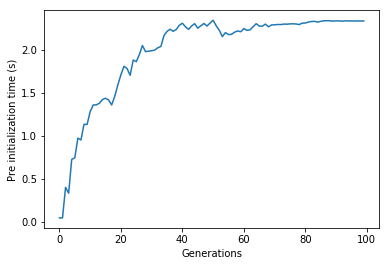

In [7]:
# error_shade(hyper_dict["individual.init_time"].mean(axis = 1)*10, 
#             hyper_dict["individual.init_time"].std(axis = 1)*10 / np.sqrt(10))
plt.plot(hyper_dict["individual.init_time"].mean(axis = 1) * 10,)
# plt.xticks([0,5,10,15,20])
plt.xlabel("Generations")

plt.ylabel("Pre initialization time (s)")

In [8]:
gen    = n_gens-1
Gnets  = torch.zeros(n_ins, 3000)
inits  = torch.zeros(n_ins, dtype = int)
r2     = torch.zeros(n_ins)
testid = torch.zeros(n_ins, 5)
# Ws     = torch.zeros(n_ins)
# bs     = torch.zeros(n_ins)

for i in range(n_ins):
    temp = pkl_load(data_path+f"results/gen_{gen:04d}_ind_{i:04d}.pkl")
    Gnets[i] = temp["netG"]
    inits[i] = int(temp["params"]["init_time"].item() * 10000)
    r2[i]  = temp["tests"][:,1].mean()
    testid[i] = temp["tests"][:,0]


In [9]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

from tqdm import tqdm

In [28]:
def prepare_network(index = 0):
    snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_new/"
    adj = torch.tensor(pkl_load(snn_data_path + "con0.pkl")["adj_matrix"])
    net = NWN(adj, "sydney")

    # net.params["Ron"]       = 1e4
    net.params["Ron"]       = 1e1
    net.params["Roff"]      = 1e4
    net.params["grow"]      = 5
    net.params["decay"]     = 10
    net.params["precision"] = True
    return net

In [29]:
volterra_path = "/home/rzhu/data_access/l2l_data/volterra_data_new/"
lambda_dict   = pkl_load(volterra_path+"lambda_data.pkl")

In [12]:
# X,Y        = pkl_load(volterra_path+f"pair_0.pkl")
X,Y        = pkl_load(volterra_path+f"pair_0")
steps      = len(X)
n_in       = 1
n_out      = 64
# torch.manual_seed(0)
readout    = torch.zeros(steps, n_out)

lambda_dict          = pkl_load(volterra_path+"lambda_data.pkl")
electrodes           = lambda_dict["electodes"]

np.random.seed(0)
elec_out  = np.random.choice(1024, size = (1,n_out), replace=None)
np.random.seed()

tensor_dict = {}
dtype_here  = torch.get_default_dtype()

In [45]:
params = pkl_load(data_path+f"results/gen_{99:04d}_ind_{5:04d}.pkl")["params"]

In [46]:
steps = 10000
W_in  = params["W_in_mean"] * 3
b_in  = params["b_in_mean"]
net   = prepare_network()

net.junction_state.L = lambda_dict["lambda"][2500]
# net.junction_state.L = lambda_dict["lambda"][int(params["init_time"] * 10000)]


for t in tqdm(range(steps)):
# for t in tqdm(range(30)):
    sig_in = torch.zeros(len(electrodes))
    sig_in[0] = X[t] * W_in + b_in
    net.sim(sig_in.reshape(1,-1), electrodes)
    readout[t,:] = net.V[elec_out]
    # netG[t]      = net.I[-1] / sig_in[0]

100%|██████████| 10000/10000 [03:55<00:00, 42.38it/s]


In [57]:
train_range = torch.arange(2000,9000)
test_range  = torch.arange(9000,10000)

# train_range = torch.arange(1000, 3000)
# test_range  = torch.arange(500,1000)

In [58]:
index   = np.random.randint(100)
_,Y     = pkl_load(volterra_path + f"pair_{index}")
# _,Y     = pkl_load(volterra_path + f"pair_{index}.pkl")

# lhs = torch.hstack((
        # torch.ones(len(train_range),1), 
        # readout[train_range]))

# lhs = torch.hstack((X[train_range].reshape(-1,1), 
#                    readout[train_range]))
# lhs = readout
lhs = torch.nn.functional.softmax(readout, 0)


rhs = Y

weight, train_result, rcond = best_regress(lhs, rhs)

In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [60]:

# Always scale the input. The most convenient way is to use a pipeline.
# reg = make_pipeline(StandardScaler(),
#             linear_model.SGDRegressor(max_iter=10000000, tol=1e-1))
# reg = make_pipeline(StandardScaler(),
#             linear_model.RidgeCV())
# alphas   = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]
# alphas = 10**np.linspace(-4,0,5)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
model  = linear_model.RidgeCV(
                            alphas = alphas,
                            cv     = KFold(10),
                                 )

filter = SelectFromModel(model)
reg    = make_pipeline(
                StandardScaler(),
                filter, 
                model
                )
        
reg.fit(lhs[train_range], rhs[train_range])
predict = reg.predict(lhs)

print(mean_squared_error(
                        predict[test_range], 
                        rhs[test_range]
                        ))

0.4310556538770726


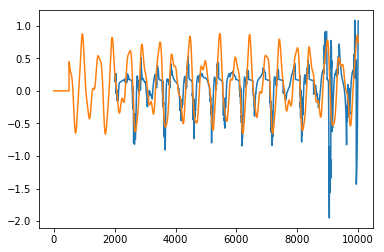

In [62]:
plt.plot(range(2000,10000), predict[2000:])
plt.plot(rhs)